In [1]:
using DifferentialEquations
using Plots

Define Precipitation `P` and PET `Ep` externally?

In [ ]:
function route(inflow, base_time, hydrograph, qremain)
    outflow = hydrograph[1]*inflow + qremain[1]
    qremain = hydrograph * inflow + qremain
    qremain = circshift(qremain, -1)
    qremain[end] = 0
    return (outflow, qremain)
end

In [ ]:
function hydrograph_half_bell(base_time)
    times = 1:ceil(base_time)
    
    SH = zeros(length(times) + 1)
    SH[1] = 0
    UH = zeros(length(times))

    for t in times
        if t <= base_time
            SH[t+1] = (t/base_time)^2.5
        elseif t > base_time
            SH[t+1] = 1
        end
        UH[t] = SH[t+1] - SH[t]
    end

    return UH
end


In [ ]:
function hydrograph_full_bell(base_time)
    times = 1:2*ceil(base_time)
    
    SH = zeros(length(times) + 1)
    SH[1] = 0
    UH = zeros(length(times))

    for t in times
        if t <= base_time
            SH[t+1] = 0.5 * (t/base_time)^2.5
        elseif base_time < t <= 2*base_time
            SH[t+1] = 1 - 0.5 * (2 - t/base_time)^2.5
        elseif t > 2*base_time
            SH[t+1] = 1
        end
        UH[t] = SH[t+1] - SH[t]
    end

    return UH
end

Initialize `Qremain` outside the equation solving loop. Also define unit hydrographs `UH_half` and `UH_full` outside loop

In [ ]:
function gr4j(du, u, p, t)
    s = u[1]
    r = u[2]
    pn = max(P - Ep, 0) #external?
    en = max(Ep - P, 0) #---"""--
    ps = pn * (1 - (s/p[1])^2)
    es = en * (2*s/p[1] - (s/p[1])^2)
    perc = p[1]^(-4) / 4 * (4/9)^(-4) * s^5
    du[1] = ps - es - perc
    fx2 = p[2] * (max(r,0)/p[3])^3.5
    qr = p[3]^(-4)/4 * r^5
    q1, qremain1 = route(0.1*(pn - ps + perc), p[4], UH_half, qremain1)
    q9, qremain9 = route(0.9*(pn - ps + perc), 2*p[4], UH_full, qremain9)
    du[2] = q9 + fx2 - qr
end

In [2]:
function bellcurve(xvec, xpeak)
    y = zeros(length(xvec))
    for (i,x) in enumerate(xvec)
        if x <= xpeak
            y[i] = 0.5 * (x / xpeak)^2.5
        elseif xpeak < x <= 2*xpeak
            y[i] = 1 - 0.5*(2 - x/xpeak)^2.5
        end
    end
    return y
end

bellcurve (generic function with 1 method)

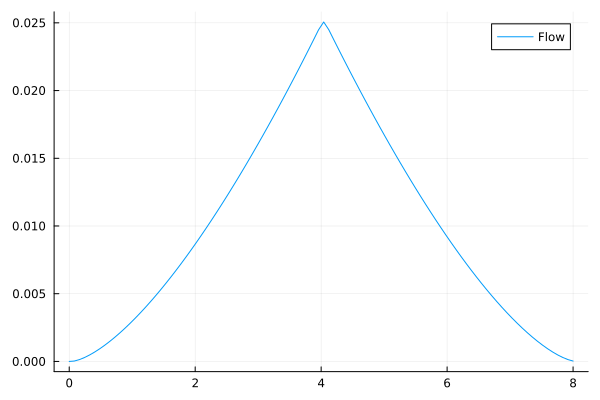

In [4]:
t = range(0, 8, length = 100)
Scurve = bellcurve(t, 4)
Uh = zeros(length(t))
Uh[2:end] = Scurve[2:end] - Scurve[1:end-1]
plot(t, Uh, label="Flow")
# plot!(t, Scurve, label="Cumulative")